In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from itertools import islice
from scipy import stats
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.utils.class_weight import compute_sample_weight

import preprocessing
import tests
import models

DATA_FILE = "data.csv"


# Reading in Data

In [2]:
# preproccess() #also removes any missing values replacing them with NaN
preprocessing.preproccess()
df = pd.read_csv(DATA_FILE)

# Cleaning the Data

In [4]:
# remove rows containing AGEGP = 1, 2 and 3 to restrict analysis on ages 16+
df = df.loc[df["AGEGP"] > 3]
# keep rows where people make more than 0 income
df = df.loc[df['ATINC'] > 0]
# keep rows where people have more than 0 wages and salaries 
df = df.loc[df['WGSAL'] > 0]
# keep rows where people have more than 0 income tax 
df = df.loc[df['INCTX'] > 0]
# sorting by after tax income
df = df.sort_values(by=['ATINC'])
# selecting relevant variables 
df = df[["PROV", "AGEGP", "SEX", "MARSTP", "HLEV2G", "SCSUM", "USHRWK", "IMMST", "MAJRI", "ATINC", "INCTX", "WGSAL"]]  # FDITX, GTR, RPPC 
# drop any missing values 
df = df.dropna()
# viewing first few lines of dataframe 
df.head()

,PROV,AGEGP,SEX,MARSTP,HLEV2G,SCSUM,USHRWK,IMMST,MAJRI,ATINC,INCTX,WGSAL
43864,35.0,13.0,1.0,1.0,4.0,12.0,15.0,2.0,2.0,250.0,4650.0,2800.0
76174,35.0,12.0,2.0,1.0,3.0,11.0,80.0,2.0,2.0,440.0,60.0,100000.0
69759,59.0,13.0,2.0,1.0,2.0,22.0,12.0,2.0,4.0,1160.0,3390.0,1800.0
84275,24.0,12.0,1.0,2.0,1.0,11.0,60.0,2.0,2.0,1240.0,4760.0,6000.0
83158,47.0,8.0,2.0,1.0,4.0,22.0,3.0,2.0,2.0,1400.0,32250.0,33000.0


# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35516 entries, 43864 to 9818
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PROV    35516 non-null  float64
 1   AGEGP   35516 non-null  float64
 2   SEX     35516 non-null  float64
 3   MARSTP  35516 non-null  float64
 4   HLEV2G  35516 non-null  float64
 5   SCSUM   35516 non-null  float64
 6   USHRWK  35516 non-null  float64
 7   IMMST   35516 non-null  float64
 8   MAJRI   35516 non-null  float64
 9   ATINC   35516 non-null  float64
 10  INCTX   35516 non-null  float64
 11  WGSAL   35516 non-null  float64
dtypes: float64(12)
memory usage: 3.5 MB


In [6]:
# summary of numerical variables
df[['ATINC','INCTX','WGSAL']].describe().round(2)

,ATINC,INCTX,WGSAL
count,35516.00,35516.00,35516.00
mean,57109.18,13363.86,62042.90
std,36362.52,19151.98,50511.66
min,250.00,10.00,25.00
25%,35290.00,4050.00,32000.00
50%,49230.00,8510.00,50000.00
75%,69692.50,16360.00,80000.00
max,922020.00,561330.00,1250000.00


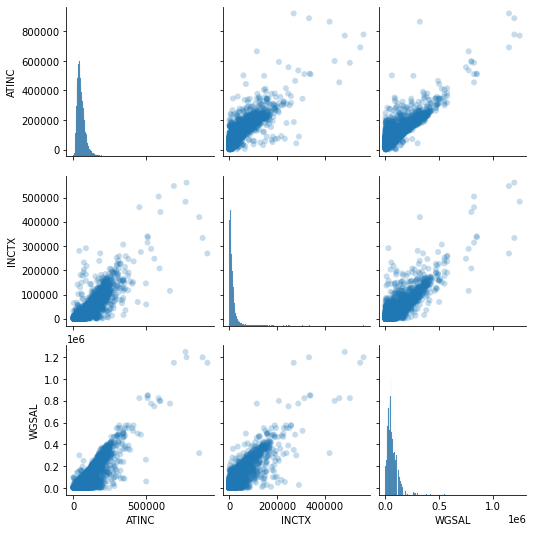

In [7]:
# Matrix scatter plot of data
sns.pairplot(df[["ATINC", "INCTX", "WGSAL"]],plot_kws=dict(edgecolor="none", alpha=0.25));

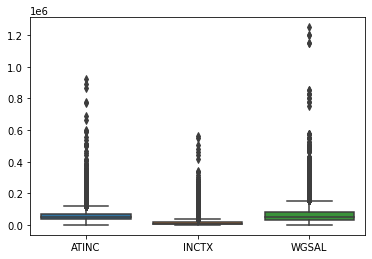

In [9]:
# Boxplot of data 
sns.boxplot(data=df[["ATINC", "INCTX", "WGSAL"]]);

In [10]:
# Correlation matrix 
df[["ATINC", "INCTX", "WGSAL"]].corr()

,ATINC,INCTX,WGSAL
ATINC,1.000000,0.866355,0.900248
INCTX,0.866355,1.000000,0.868471
WGSAL,0.900248,0.868471,1.000000


In [11]:
# making a copy of the dataframe to retain numeric values instead of strings for our model implementation later on
df_m = df.copy(deep=True)
# dropping other numerical variables as we are classifying after tax income based on demographic
df_m = df_m.drop(columns = ['INCTX','WGSAL'])

In [12]:
# mapping groups from numeric to string
df['PROV'] = df['PROV'].map({59:'BC', 48:'AB', 47:'SA', 46:'MA', 35:'ON', 24:'QU', 13:'NB', 12:'NS', 11:'PE', 10:'NL'})
df['AGEGP'] = df['AGEGP'].map({4:'16-17', 5:'18-24', 6:'25-29', 7:'30-34', 8:'35-39', 9:'40-44', 10:'45-49', 11:'50-54', 12:'55-59', 13:'60-64', 14:'65-69', 15:'70+'})
df['SEX'] = df['SEX'].map({1:'Male', 2:'Female'})
df['MARSTP'] = df['MARSTP'].map({1:'Married', 2:'Common-Law', 3:'Separated', 4:'Single'})
df['HLEV2G'] = df['HLEV2G'].map({1:'Less than HS', 2:'Graduated HS', 3:'Certificate or Diploma', 4:'University Degree'})
df['SCSUM'] = df['SCSUM'].map({11:'Full-Year Full-Time', 12:'Full-Year Part-Time', 21:'Part-Year Full-Time', 22:'Part-Year Part-Time', 30:'Did not work during year'})
df['IMMST'] = df['IMMST'].map({1:'Immigrant', 2:'Non-Immigrant'})
df['MAJRI'] = df['MAJRI'].map({1:'No Income', 2:'Wages and Salary', 3:'Self-Employment', 4:'Government Transfers',5:'Investment',6:'Private Retirement Pensions', 7:'Other'})

In [13]:
# Log transforming data due to the distribution of variables being right skewed 
dflog = df.copy(deep=True)
logged_vars= dflog[["ATINC", "INCTX", "WGSAL"]].apply(lambda x: np.log(x))
dflog[["ATINC", "INCTX", "WGSAL"]] = logged_vars

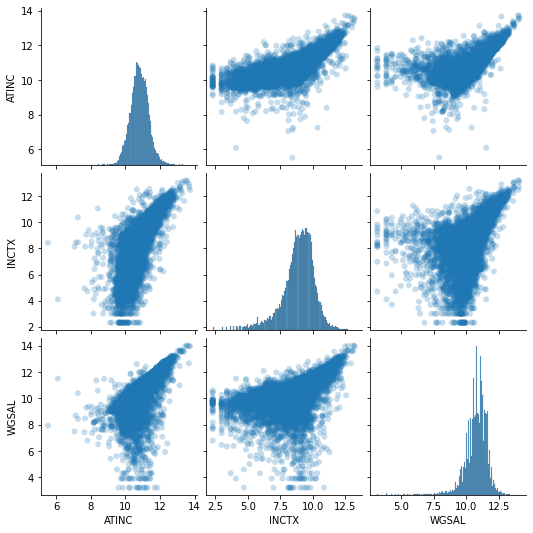

In [14]:
# Matrix scatter plot of log transformed data 
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL"]], plot_kws=dict(edgecolor="none", alpha=0.25));

### Statistical tests

T-Test p-value: 2.872864049892834e-282


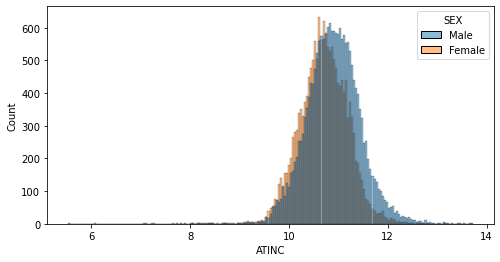

In [15]:
# Test to determine whether an individuals after tax income is affected by their gender.
rcParams['figure.figsize'] = 8,4 
tests.income_gender(dflog)
# since the p-value < 0.05, there is sufficient evidence to reject the null hypothesis that both male and female after tax income are the same 
# therefore we conclude the income for male and females are different

In [16]:
# Test to determine whether the after tax income for immigrants is different than non-immigrants 
tests.imm_income(dflog)
# p-value > 0.05, so we can conclude the after tax income for immigrants and non-immigrants are not different

T-test p-value: 0.12133861508348939


ANOVA p-value: 0.0
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
   common_law       married    0.122 0.001  0.1019  0.1421   True
   common_law never_married  -0.2039 0.001 -0.2271 -0.1807   True
   common_law     seperated   0.0596 0.001  0.0295  0.0896   True
      married never_married  -0.3259 0.001 -0.3436 -0.3082   True
      married     seperated  -0.0624 0.001 -0.0884 -0.0364   True
never_married     seperated   0.2635 0.001   0.235   0.292   True
-----------------------------------------------------------------


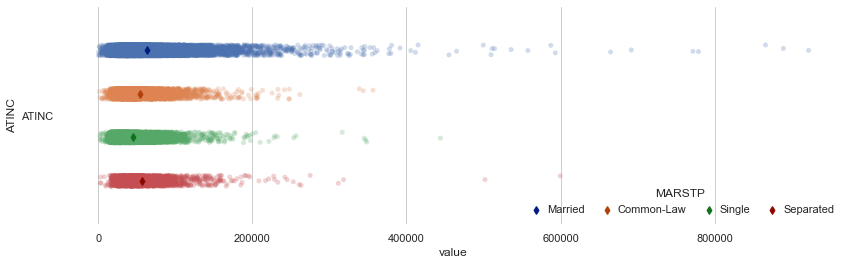

In [17]:
# ANOVA test to determine if the after tax income of marital status differs
tests.anova(dflog)
# p-value < 0.05 hence we have sufficient evidence to reject the null hypothesis that the means of the groups are the same
# to conclude, the means of the groups are different 
rcParams['figure.figsize'] = 14,4  
tests.stripplot(df[['MARSTP', 'ATINC']], 'ATINC', 'MARSTP')


ANOVA p-value: 5.926676871921004e-256 

                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
           group1                      group2           meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------
       Government Transfers                  Investment   0.7975  0.001  0.7177  0.8774   True
       Government Transfers                       Other   0.5515  0.001   0.434  0.6689   True
       Government Transfers Private Retirement Pensions   0.5566  0.001  0.4843   0.629   True
       Government Transfers             Self-Employment   0.3742  0.001  0.2845  0.4639   True
       Government Transfers            Wages and Salary   0.4955  0.001  0.4509  0.5402   True
                 Investment                       Other  -0.2461  0.001 -0.3738 -0.1183   True
                 Investment Private Retirement Pensions  -0.2409  0.001  -0.329 -0.1528   True
         

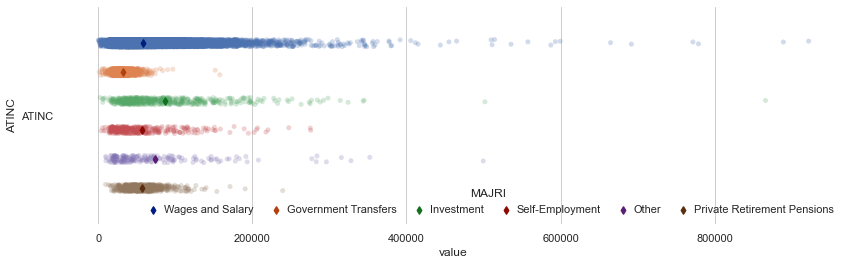

In [18]:
# Test to determine peoples major source of income difference 
tests.major_source(dflog)
# p-value < 0.05 hence we have sufficient evidence to reject the null hypothesis that the means of the groups are the same
# to conclude, the means of the groups are different 
rcParams['figure.figsize'] = 14,4  
tests.stripplot(df[['MAJRI', 'ATINC']], 'ATINC', 'MAJRI')


In [19]:
# Test to determine whether marital status and highest level of education obtained are independent from each other 
# creating contingency table and output of chi square test
tests.chi_test(df, 'HLEV2G', 'MARSTP')
# since p-value < 0.05 we have sufficient evidence to reject the null hypothesis that the categories are independent
# Therefore, we can conclude the categories are indeed dependant on each other

MARSTP                  Common-Law  Married  Separated  Single
HLEV2G                                                        
Certificate or Diploma        2431     7101       1286    2653
Graduated HS                  1217     4130        707    2530
Less than HS                   367     1163        239     567
University Degree             1471     6989        709    1956
Chi-Squared Test p-value for HLEV2G and MARSTP: 5.638966913222613e-160


### Back To EDA

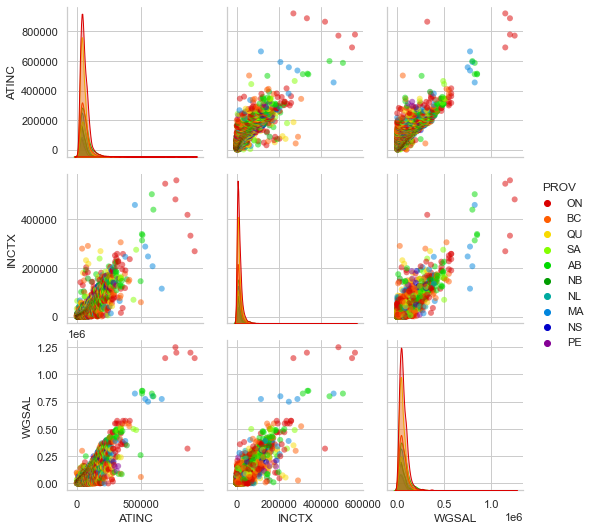

In [20]:
#sns.reset_defaults()
sns.pairplot(df[["ATINC", "INCTX", "WGSAL","PROV"]],hue="PROV",palette='nipy_spectral_r',plot_kws=dict(edgecolor="none",alpha=0.5));

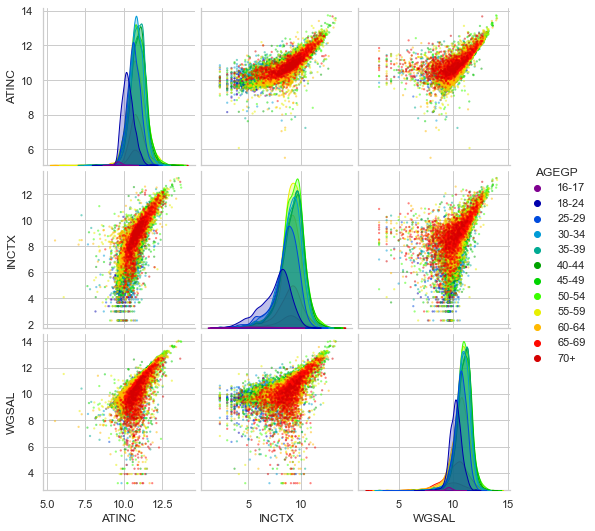

In [21]:
dflog = dflog.sort_values(by=['AGEGP'])
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","AGEGP"]],hue="AGEGP",palette='nipy_spectral', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

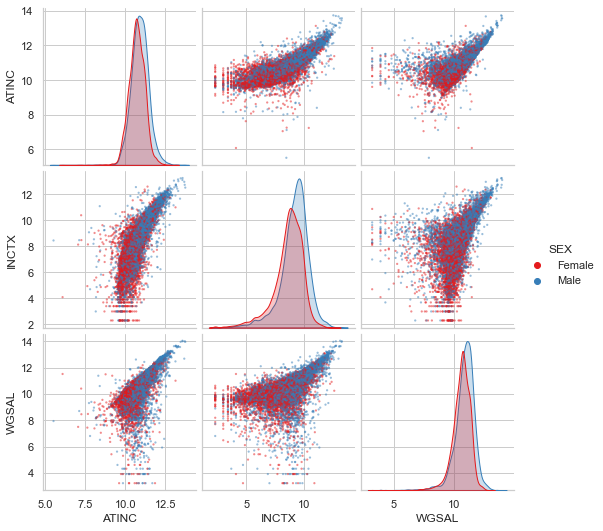

In [22]:
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","SEX"]],hue="SEX", palette='Set1', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

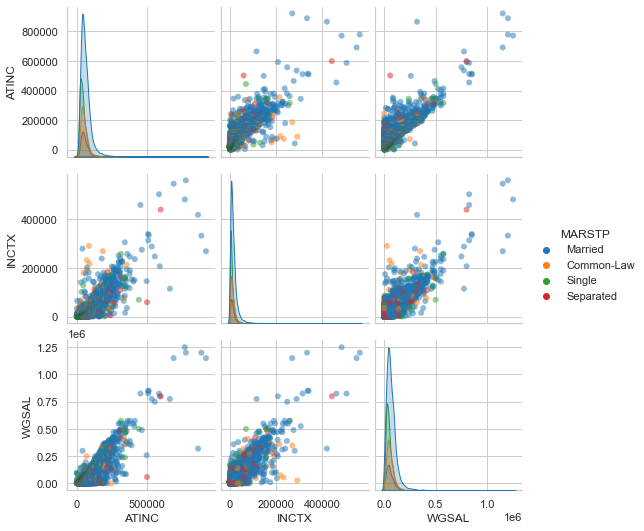

In [23]:
sns.pairplot(df[["ATINC", "INCTX", "WGSAL","MARSTP"]],hue="MARSTP",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5));

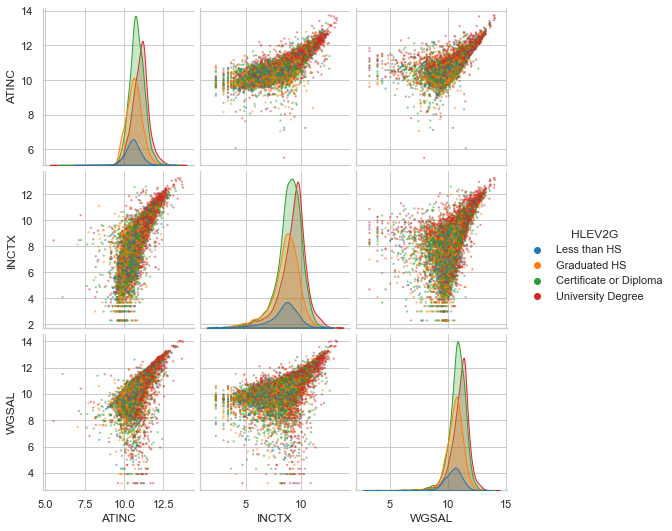

In [24]:
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","HLEV2G"]],hue="HLEV2G",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

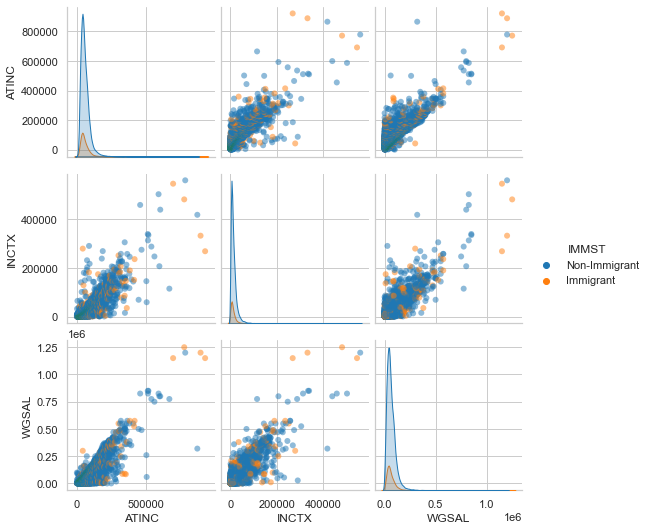

In [25]:
sns.pairplot(df[["ATINC", "INCTX", "WGSAL","IMMST"]],hue="IMMST",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5));

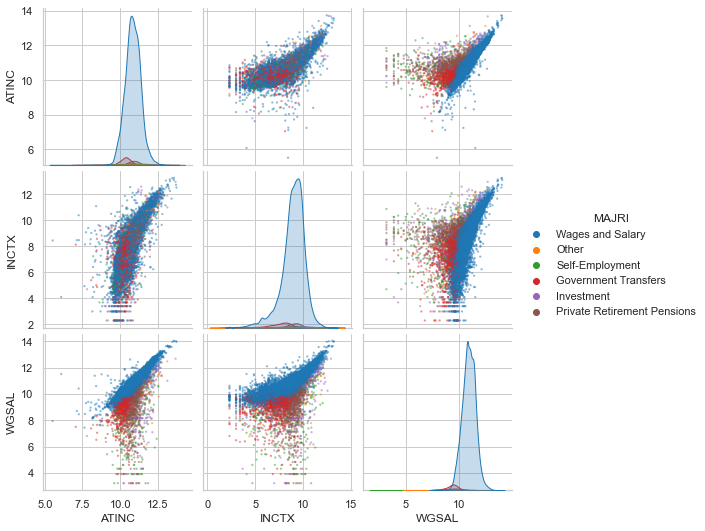

In [26]:
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","MAJRI"]],hue="MAJRI",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

In [27]:
# Categorical variables
cat_features = df[["PROV", "AGEGP", "SEX", "MARSTP", "HLEV2G", "SCSUM", "IMMST", "USHRWK", "MAJRI"]]
cat_features
# Feature names for our plots
values = ["Province", "Age Group", "Gender", "Marital Status", "Highest Level of Education", "Yearly Summary of Time Worked", "Immigration Status", "Average Hours Worked per Week", "Major Source of Income"]
cat_dict = dict(zip(cat_features.columns, values))

In [28]:
# Outputting mean after tax income for the groups in each categorical variable
for feature in cat_features:
    print(df[[feature, 'ATINC']].groupby(by=[feature]).mean().round(2),'\n')

         ATINC
PROV          
AB    67804.35
BC    60036.88
MA    53206.33
NB    50737.83
NL    53899.91
NS    51163.23
ON    59520.13
PE    47632.16
QU    50844.72
SA    60346.53 

          ATINC
AGEGP          
16-17  15953.70
18-24  30660.40
25-29  45525.72
30-34  54035.98
35-39  60189.14
40-44  62910.47
45-49  63672.30
50-54  62216.25
55-59  60359.63
60-64  57046.84
65-69  59732.80
70+    63718.71 

           ATINC
SEX             
Female  50083.83
Male    63117.95 

               ATINC
MARSTP              
Common-Law  53783.89
Married     63000.08
Separated   57409.68
Single      44544.34 

                           ATINC
HLEV2G                          
Certificate or Diploma  55059.20
Graduated HS            46680.54
Less than HS            43942.76
University Degree       70402.78 

                        ATINC
SCSUM                        
Full-Year Full-Time  61632.17
Full-Year Part-Time  39648.79
Part-Year Full-Time  48354.40
Part-Year Part-Time  39353.02 

            

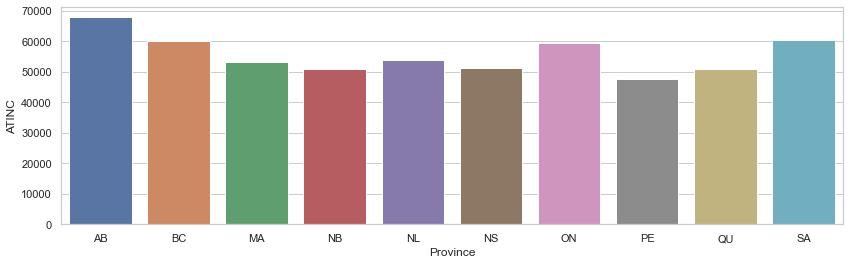

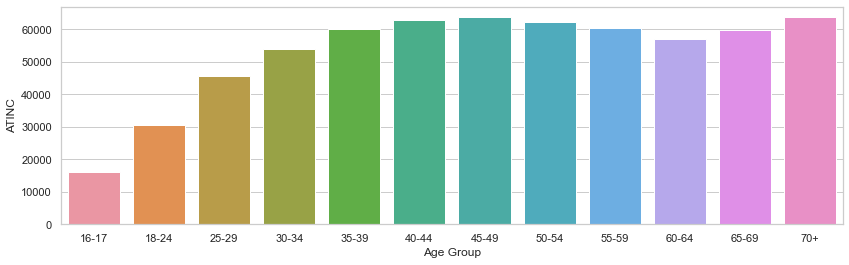

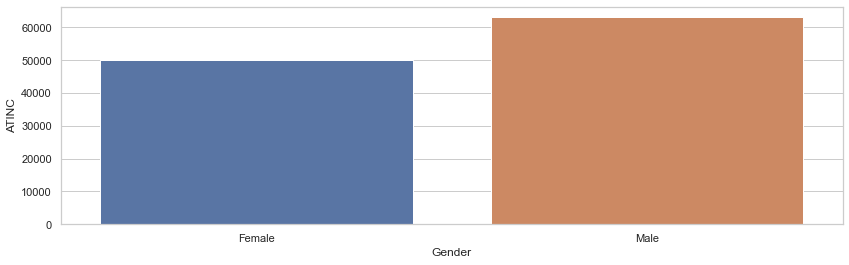

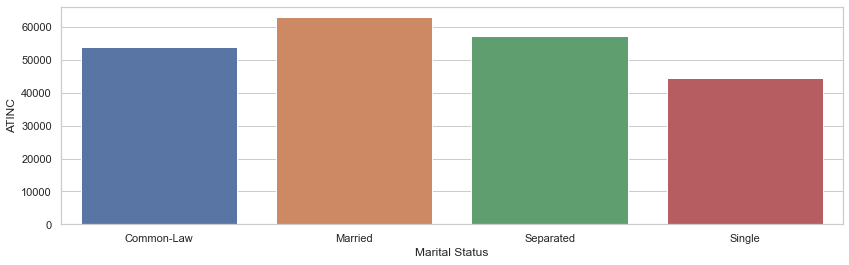

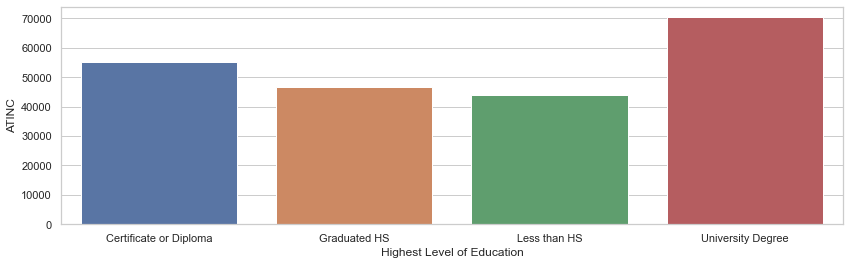

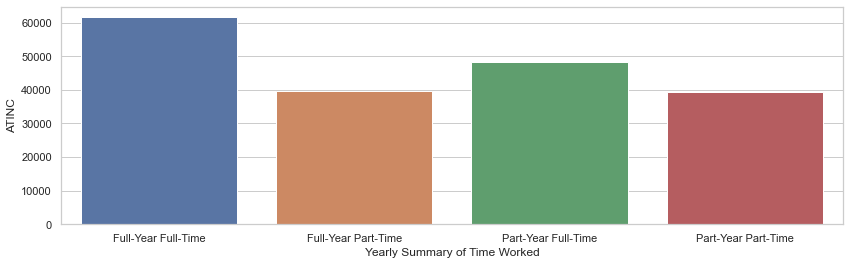

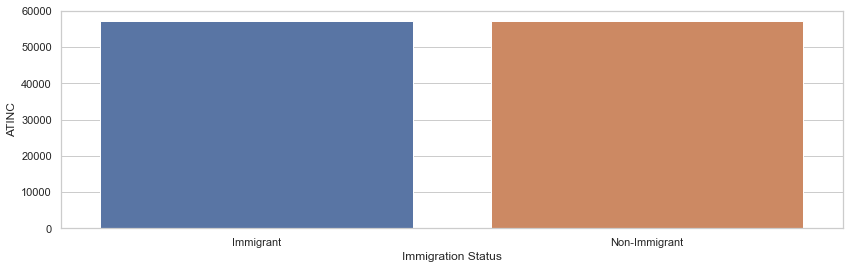

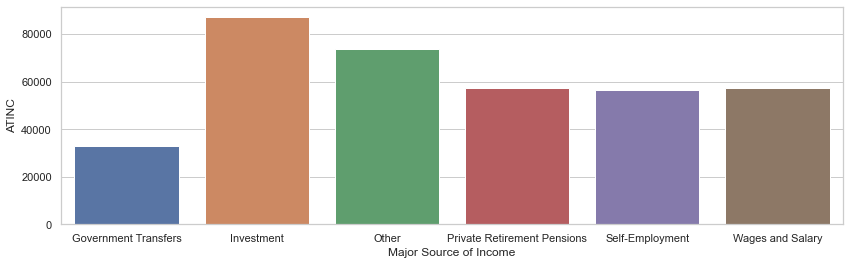

In [29]:
# barplots for average after tax income for the different groups in each categorical variable 
for features in cat_features:
    rcParams['figure.figsize'] = 14,4 
    if features != 'USHRWK':
        group = df[[features, 'ATINC']].groupby(by=[features]).mean().round(2)
        sns.barplot(x=group.index, y=group['ATINC']).set(xlabel=cat_dict[features]);
        plt.show()

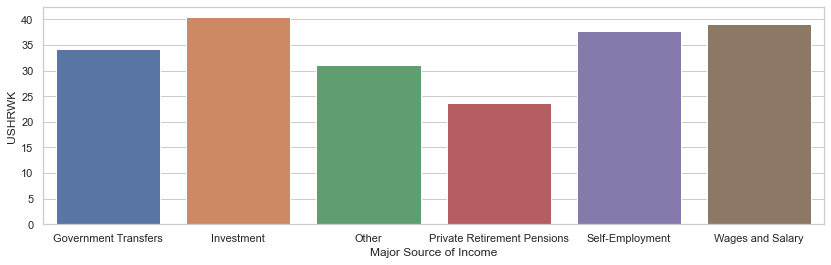

In [30]:
# Plot of average hours worked per week and major source of income 
rcParams['figure.figsize'] = 14,4
group = df[['MAJRI', 'USHRWK']].groupby(by=['MAJRI']).mean().round(2)
sns.barplot(x=group.index, y=group['USHRWK']).set(xlabel='Major Source of Income');

In [31]:
# distribution of the groups in each of the categorical variables
for col in list(cat_features.columns):
    print(col +' has '+ str(cat_features[col].nunique()) +' unique elements:\n ' + str(cat_features[col].unique())) 
    print('The distributions:')
    print(round(df[col].value_counts(normalize=True)*100,2).map(str)+'%') 
    print('\n')

PROV has 10 unique elements:
 ['ON' 'BC' 'QU' 'SA' 'AB' 'NB' 'NL' 'MA' 'NS' 'PE']
The distributions:
ON    27.88%
QU    18.53%
AB    11.42%
BC    11.09%
MA     7.94%
SA     7.07%
NB     5.03%
NS     4.83%
NL     3.51%
PE      2.7%
Name: PROV, dtype: object


AGEGP has 12 unique elements:
 ['60-64' '55-59' '35-39' '45-49' '30-34' '50-54' '18-24' '40-44' '65-69'
 '25-29' '16-17' '70+']
The distributions:
50-54    12.71%
55-59    12.67%
35-39    11.58%
45-49    11.55%
30-34    11.23%
40-44     11.1%
60-64     9.22%
25-29     8.69%
18-24     5.99%
65-69     3.95%
70+       1.17%
16-17     0.14%
Name: AGEGP, dtype: object


SEX has 2 unique elements:
 ['Male' 'Female']
The distributions:
Male      53.9%
Female    46.1%
Name: SEX, dtype: object


MARSTP has 4 unique elements:
 ['Married' 'Common-Law' 'Single' 'Separated']
The distributions:
Married       54.58%
Single         21.7%
Common-Law    15.45%
Separated      8.28%
Name: MARSTP, dtype: object


HLEV2G has 4 unique elements:
 ['Univer

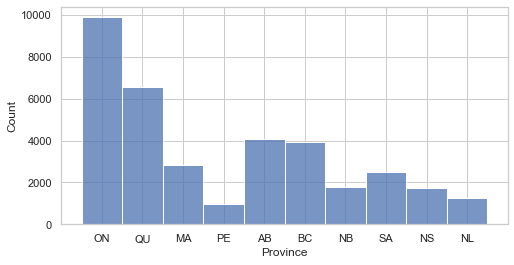

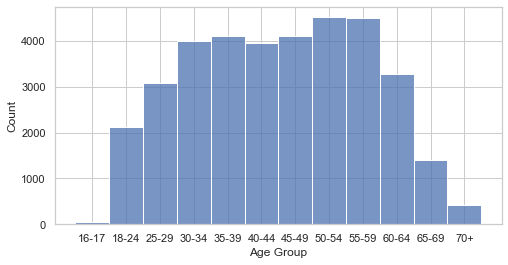

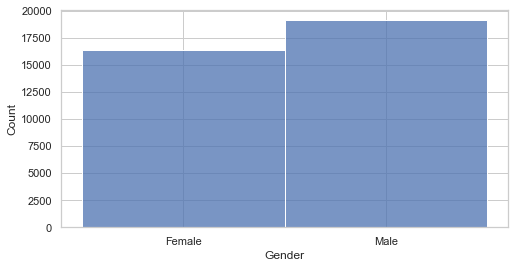

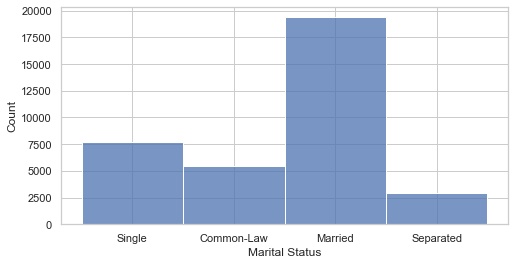

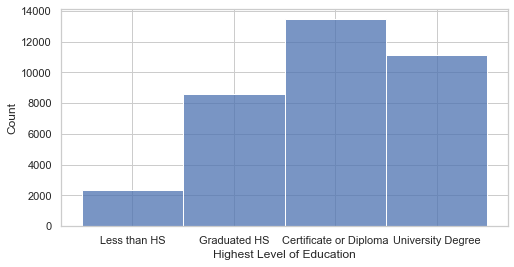

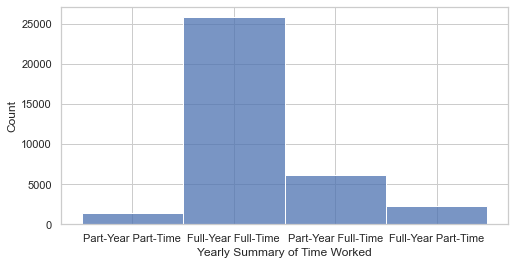

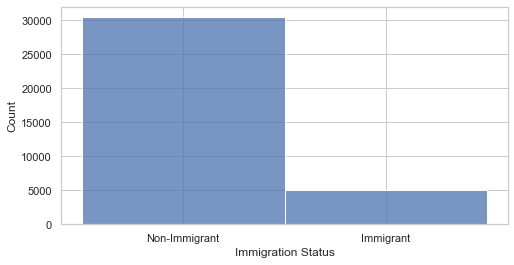

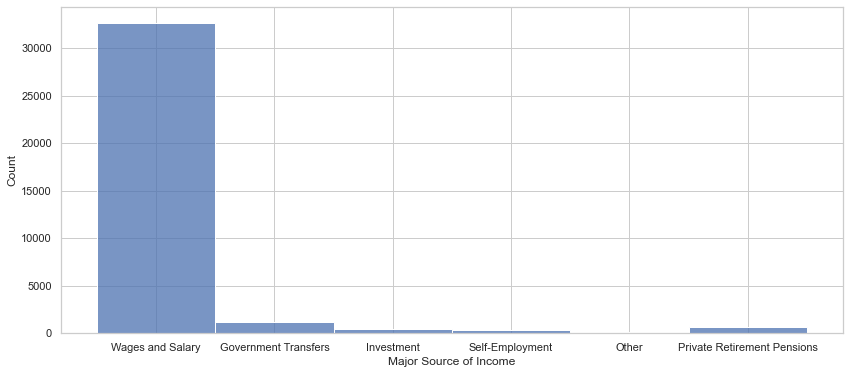

In [32]:
rcParams['figure.figsize'] = 8,4
for features in cat_features:
    if features != 'USHRWK':
        if features == 'MAJRI':
            rcParams['figure.figsize'] = 14,6
            sns.histplot(data=df, x=features).set(xlabel=cat_dict[features]);
            plt.show()
        else:
            rcParams['figure.figsize'] = 8,4
            sns.histplot(data=df.sort_values(by='AGEGP'), x=features).set(xlabel=cat_dict[features]);
            plt.show()

In [33]:
# classifying ATINC variable (after tax income), with our income_classifier function 
income=[]
income =(pd.concat([cat_features, df["ATINC"]], axis=1))
income['ATINC'] = income.apply(models.income_classifier, axis=1)

In [34]:
# Distribution of income levels for the groups in each of our categorical variables
for col in income.columns:
    x= income.groupby([col,'ATINC'])['ATINC'].count() # counting the income level class per group within a categorical variable
    y= income.groupby([col])['ATINC'].count() # counting the total number of income level class per group within a categorical variable
    r = round((x/y)*100,2).map(str)+'%' 
    print(r)
    print('\n')

PROV  ATINC       
AB    Low             18.69%
      Lower-middle    20.27%
      Middle           24.9%
      Upper           10.58%
      Upper-middle    25.57%
BC    Low             23.29%
      Lower-middle    22.91%
      Middle          25.24%
      Upper             6.5%
      Upper-middle    22.07%
MA    Low             28.71%
      Lower-middle    26.44%
      Middle           24.6%
      Upper            3.33%
      Upper-middle    16.91%
NB    Low             32.47%
      Lower-middle     25.7%
      Middle          25.48%
      Upper             3.7%
      Upper-middle    12.65%
NL    Low             28.17%
      Lower-middle    26.73%
      Middle          22.71%
      Upper            4.01%
      Upper-middle    18.38%
NS    Low             30.23%
      Lower-middle    27.49%
      Middle          23.18%
      Upper            2.74%
      Upper-middle    16.37%
ON    Low             22.68%
      Lower-middle     24.2%
      Middle          24.63%
      Upper            5

In [35]:
# updating dataframes with income level classification 
df['ATINC'] = income['ATINC']
df_m['ATINC'] = income['ATINC']

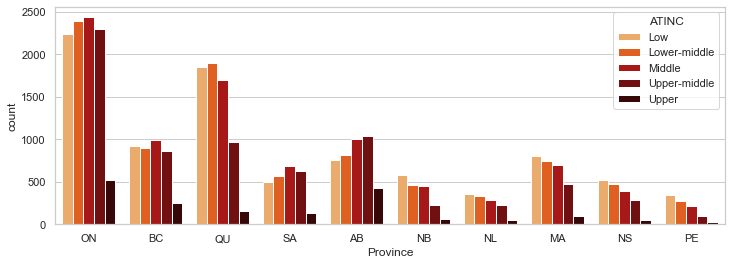

In [36]:
rcParams['figure.figsize'] = 12,4
sns.countplot(data=df,x='PROV', hue='ATINC', palette="gist_heat_r").set(xlabel='Province');

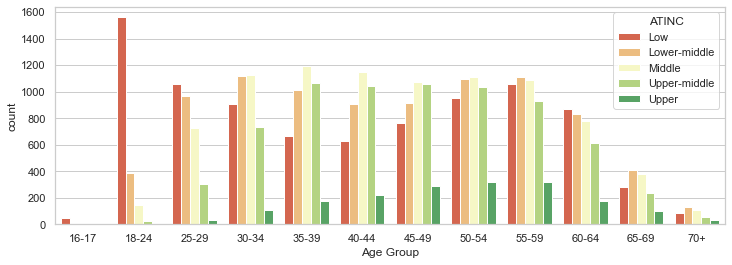

In [37]:
df = df.sort_values(by= 'AGEGP')
sns.countplot(data=df,x='AGEGP', hue='ATINC', palette="RdYlGn").set(xlabel='Age Group');


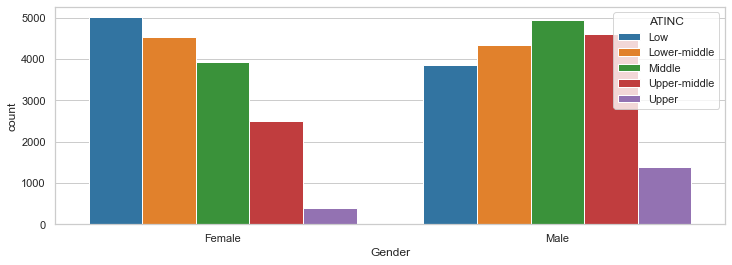

In [38]:
sns.countplot(data=df,x='SEX', hue='ATINC', palette="tab10").set(xlabel='Gender');

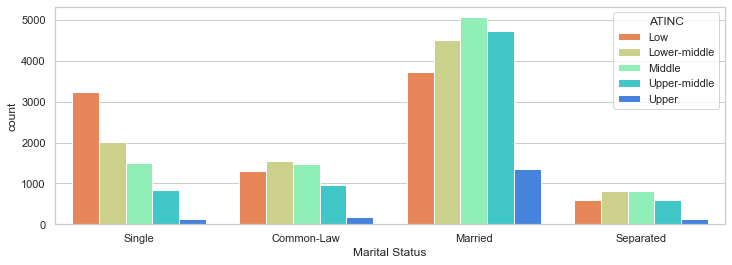

In [39]:
# Individual income distribution by marital status
sns.countplot(data=df,x='MARSTP', hue='ATINC', palette="rainbow_r").set(xlabel='Marital Status');

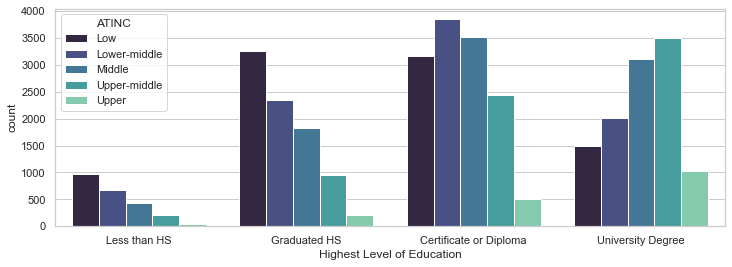

In [40]:
# Individual income distribution by highest level of education
sns.countplot(data=df,x='HLEV2G', hue='ATINC', palette="mako").set(xlabel='Highest Level of Education');

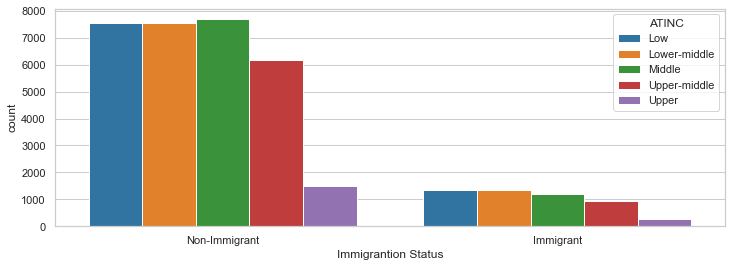

In [41]:
# Individual income distribution by if person is a landed immigrant 
sns.countplot(data=df,x='IMMST', hue='ATINC', palette="tab10").set(xlabel='Immigrantion Status');

In [42]:
# Visualization of our samples based on income levels, don't need this anymore since distribution based on percentiles now 
# print("Number of samples based on income levels")
# print("Low:", df.loc[df['ATINC']=="Low"].count()['ATINC'])
# print("Low-middle:", df.loc[df['ATINC']=="Lower-middle"].count()['ATINC'])
# print("Middle:", df.loc[df['ATINC']=="Middle"].count()['ATINC'])
# print("Upper-middle:", df.loc[df['ATINC']=="Upper-middle"].count()['ATINC'])
# print("Upper:", df.loc[df['ATINC']=="Upper"].count()['ATINC'])

# rcParams['figure.figsize'] = 12,8
# dist = df['ATINC'].value_counts(normalize=True)*100
# plt.pie(dist, labels=dist.index,  autopct= '%2.2f%%');
# plt.legend(dist.index, loc="best");
# plt.title('Distribution of Individuals Income Levels');

# Implementing Models

In [43]:
# Getting the data
X = df_m.drop(['ATINC'], axis=1)
y = df_m['ATINC']

# Partition the data into trianing and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y)

# weights
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
dictionary = dict(zip(y_train, sample_weights))

0.38893268761497163
0.3820250028156324
              precision    recall  f1-score   support

         Low       0.53      0.53      0.53      2220
Lower-middle       0.34      0.26      0.29      2220
      Middle       0.32      0.33      0.32      2219
Upper-middle       0.18      0.13      0.15       444
       Upper       0.37      0.47      0.41      1776

    accuracy                           0.38      8879
   macro avg       0.35      0.35      0.34      8879
weighted avg       0.38      0.38      0.38      8879



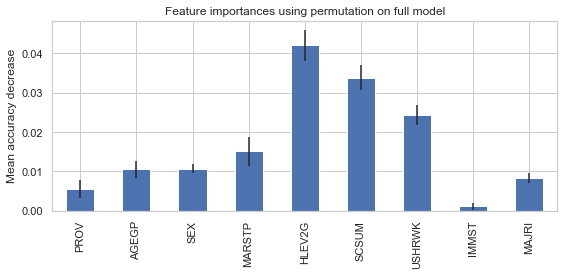

In [45]:
# naive baye classifier 
bayes_model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)
bayes_model.fit(X_train, y_train)
print(bayes_model.score(X_train, y_train))
print(bayes_model.score(X_valid, y_valid))
print(classification_report(y_valid, bayes_model.predict(X_valid), target_names=df['ATINC'].unique()))
rcParams['figure.figsize'] = 8,4
models.feature_imp(bayes_model, X_valid, y_valid)

0.3623906596088148
0.3494762923752675
              precision    recall  f1-score   support

         Low       0.51      0.60      0.55      2220
Lower-middle       0.34      0.26      0.29      2220
      Middle       0.32      0.20      0.24      2219
Upper-middle       0.15      0.61      0.24       444
       Upper       0.34      0.27      0.30      1776

    accuracy                           0.35      8879
   macro avg       0.33      0.39      0.33      8879
weighted avg       0.37      0.35      0.35      8879



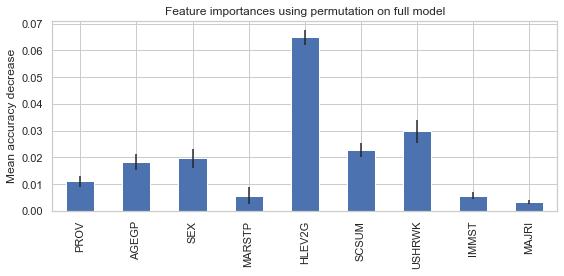

In [46]:
from sklearn.linear_model import LogisticRegression
logist_reg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight=dictionary)
) 
logist_reg_model.fit(X_train, y_train)
print(logist_reg_model.score(X_train, y_train))
print(logist_reg_model.score(X_valid, y_valid))
print(classification_report(y_valid, logist_reg_model.predict(X_valid), target_names=df['ATINC'].unique()))
models.feature_imp(logist_reg_model, X_valid, y_valid)


0.4119457896910313
0.38585426286744
              precision    recall  f1-score   support

         Low       0.57      0.60      0.59      2220
Lower-middle       0.37      0.41      0.39      2220
      Middle       0.37      0.14      0.21      2219
Upper-middle       0.17      0.62      0.27       444
       Upper       0.37      0.34      0.35      1776

    accuracy                           0.39      8879
   macro avg       0.37      0.42      0.36      8879
weighted avg       0.41      0.39      0.38      8879



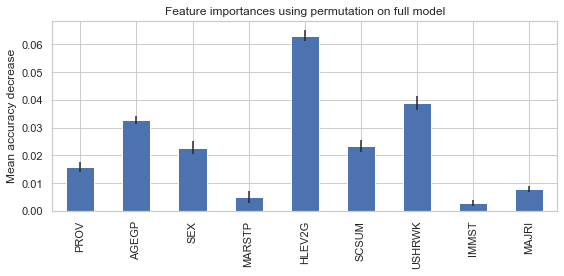

In [48]:
# random forest classifer 
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=10, class_weight = dictionary)
)
rf_model.fit(X_train, y_train)
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_valid, y_valid))
print(classification_report(y_valid, rf_model.predict(X_valid), target_names=df['ATINC'].unique()))
models.feature_imp(rf_model, X_valid, y_valid)

0.362916244321808
0.35184142358373693
              precision    recall  f1-score   support

         Low       0.54      0.54      0.54      2220
Lower-middle       0.34      0.32      0.33      2220
      Middle       0.33      0.19      0.24      2219
Upper-middle       0.15      0.62      0.24       444
       Upper       0.34      0.28      0.31      1776

    accuracy                           0.35      8879
   macro avg       0.34      0.39      0.33      8879
weighted avg       0.38      0.35      0.35      8879



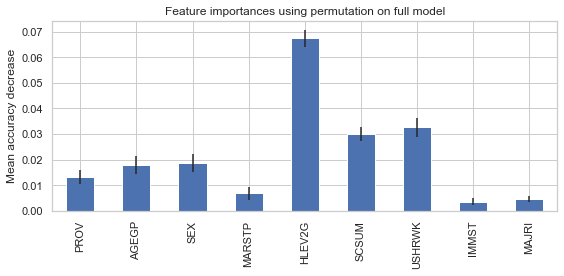

In [49]:
# SVC
svc_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', C=1.0, class_weight = dictionary)
)
svc_model.fit(X_train, y_train) 
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_valid, y_valid))
print(classification_report(y_valid, svc_model.predict(X_valid), target_names=df['ATINC'].unique()))
models.feature_imp(svc_model, X_valid, y_valid)